In [1]:
# calculate avg error given an output file

In [2]:
import numpy as np

In [104]:
#filename = './Experiments/test_1var_simple_mesh_GPT2_XYSorted_1024_88000.out'
filename = './Experiments/test_1var_simple_mesh_GPT2_SortedY_1024_82000.out'

In [105]:
testCaseTemplate = 'Test case {}/{}'
resultDict = {}

with open(filename, 'r') as f:
    lines = f.readlines()
    for line in lines:
        #print(line)
        if 'Test case' in line:
            st = line.split('Test case ')[1].strip('.')
            idx, _ = st.split('/') 
            idx = eval(idx)
        elif 'Not calculated!' in line:
            continue
        elif ':' in line:
            modelName, err = line.split(': ')
            err = err.strip('\n')
            err = eval(err)
            
            if modelName in resultDict.keys():
                resultDict[modelName].append(err)
            else:
                resultDict[modelName] = [err]

In [114]:
lines

['Test case 0/1000.\n',
 '-sin(1.1*x1+0.64)\n',
 'GPT2: Not calculated!\n',
 '-sin(1.18*x1+0.sqrt(0.58)\n',
 '\n',
 'Test case 1/1000.\n',
 '-1.42*x1+sqrt(x1+0.53)\n',
 'GPT2: 4.337153725950505\n',
 '-0.79*x1+0.94*sqrt(0.7*x1-1)\n',
 'MLP: 4.841184431810175\n',
 '(neural black box)\n',
 'GP: 0.14179403939488147\n',
 'div(add(0.699, mul(X0, -0.882)), 0.855)\n',
 '\n',
 'Test case 2/1000.\n',
 'sqrt(-sin(0.2*x1))\n',
 'GPT2: 0.004482293597599293\n',
 '0.44*sqrt(x1)\n',
 'MLP: 0.024855029611200802\n',
 '(neural black box)\n',
 'GP: 0.0020305663362305574\n',
 'add(sin(sqrt(mul(0.216, X0))), mul(sin(sqrt(-0.526)), log(div(X0, X0))))\n',
 '\n',
 'Test case 3/1000.\n',
 'sin(sqrt(x1))\n',
 'GPT2: Not calculated!\n',
 'sin(sqrt(x1)))\n',
 '\n',
 'Test case 4/1000.\n',
 '0.86*x1**2-0.59*x1+1.36\n',
 'GPT2: 1.9933840311937319\n',
 '0.88*x1**2-1.32*x1+sqrt(x1+0.96)+0.45\n',
 'MLP: 37.70691295347149\n',
 '(neural black box)\n',
 'GP: 290.9822195113881\n',
 'sqrt(mul(sqrt(exp(add(X0, -0.977))), exp

In [107]:
# # if there is a data.json with resultDict
# # laod the file
# import json
# with open('./data.json', 'r', encoding="utf-8") as h:
#     resultDict = json.load(h)
# resultDict = resultDict['D:/Datasets/Symbolic Dataset/Datasets/Mesh_Simple_GPT2/TestDataset\\Test.json']

In [108]:
# add optimistic results for seq2seq based on MLP + 10% improvement
#mean = np.mean(resultDict['MLP'])
#xpercent = 0.1 # 10%
#resultDict['SEQ2SEQ'] = [x-xpercent*x for x in resultDict['MLP']]

In [109]:
import copy
def MSE2RMSE(err):
    return np.sqrt(err)

resultDictRMSE = copy.copy(resultDict)
for key in resultDict:
    resultDictRMSE[key] = [MSE2RMSE(x) for x in resultDict[key]]

In [110]:
ranges = [0.05,0.1,0.2]
percentage = {key:[] for key in list(resultDict)+['Seq2Seq']}
#percentage['Seq2Seq'] = [15.3,22.34,37.09] 
for key in resultDict:
    model = np.array(resultDictRMSE[key])
    for r in ranges:
        percentage[key].extend([np.round(len(model[model<r])/len(model)*100,2)])
percentage['Seq2Seq'] = [np.round(v+20,2) for v in percentage['MLP']]

In [113]:
percentage

{'GPT2': [44.47, 52.69, 60.06],
 'MLP': [5.37, 9.27, 17.7],
 'GP': [44.68, 51.32, 60.7],
 'Seq2Seq': [25.37, 29.27, 37.7]}

In [111]:
for key in resultDict:
    print('{} avg err is {}, median {}'.format(key,
                                    np.mean(resultDict[key]),
                                    np.median(resultDict[key])))

GPT2 avg err is 758.5404458785597, median 0.006037733646420562
MLP avg err is 613.4460469760012, median 0.5530201943479746
GP avg err is 705.0593614971181, median 0.007908402958032933


Text(0, 0.5, 'Cumulative Normalized Frequency')

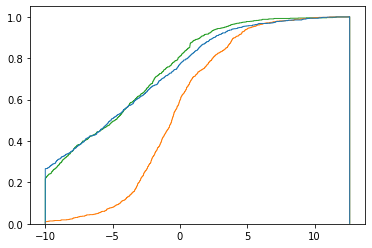

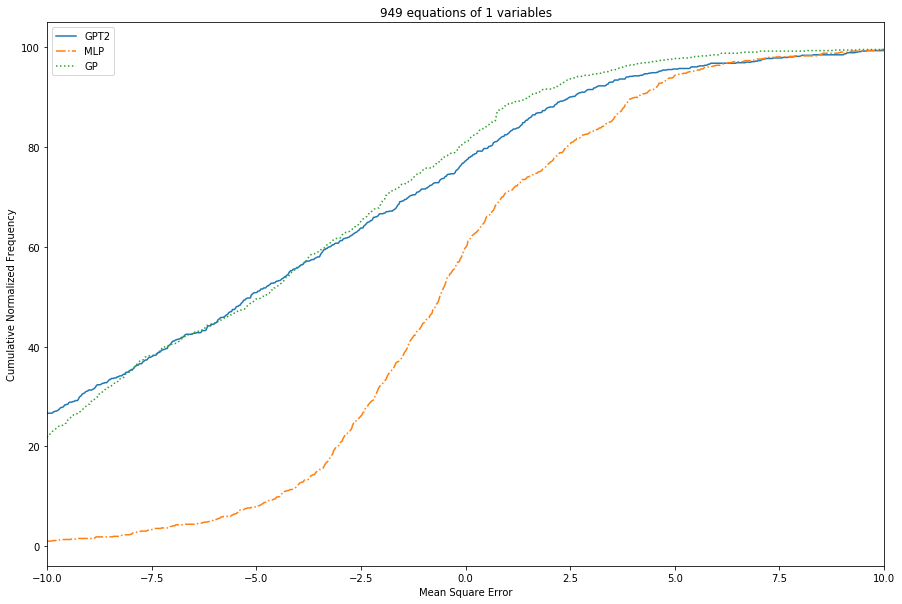

In [112]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict['GPT2'])
num_vars = 1

models = list(resultDict.keys())
lists_of_error_scores = [resultDict[key] for key in models]
linestyles = ["-","dashdot","dotted","--"]

y, x, _ = plt.hist([np.log(e) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=1000, 
                   density="true")
plt.figure(figsize=(15, 10))

for idx, model in enumerate(models): 
  plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=model)

plt.xlim([-10, 10])

plt.legend(loc="upper left")
plt.title("{} equations of {} variables".format(num_eqns, num_vars))
plt.xlabel("Mean Square Error")
plt.ylabel("Cumulative Normalized Frequency")